In [1]:
# import required dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle

In [2]:
# read the validation data
val_data = pd.read_csv('../data/validation.csv')

In [3]:
# import the notes_embedded.csv
notes = pd.read_csv('../data/notes_embedded.csv')

In [10]:
# import the mortality prediction from Wen Rui's model
mortality = pd.read_csv('../data/Validation_death_combined_3.csv')

In [4]:
# function to convert embedding string into numpy
def convert_to_np(string):
    ss = string.strip('[]').split()
    return np.array(ss, dtype=float)

In [5]:
# helper function to plot ROC curve
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(models, Xtest, ytest):
    plt.figure(figsize=(10,8))
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            ypred_proba = model.predict_proba(Xtest)[:, 1]
        elif hasattr(model, 'decision_function'):
            ypred_proba = model.decision_function(Xtest)
        # for neural network
        else:
            model.eval()
            Xtest_tensor = torch.FloatTensor(Xtest)
            with torch.no_grad():
                outputs = model(Xtest_tensor)
                ypred_proba = torch.sigmoid(outputs).cpu().numpy()  # convert output to probabilities using sigmoid function

        fpr, tpr, thresholds = roc_curve(ytest, ypred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    plt.plot([0,1],[0,1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.4)
    plt.show()

In [6]:
# helper function to check model performance based on selected metrics
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

def eval_metrics(models, Xtest, ytest):
    res_df = []
    for model_name, model in models.items():
        if hasattr(model, 'predict_proba'):
            ypred_proba = model.predict_proba(Xtest)[:, 1]
            ypred = model.predict(Xtest)
        elif hasattr(model, 'decision_function'):
            ypred_proba = model.decision_function(Xtest)
            ypred = model.predict(Xtest)
        # for neural network
        else:
            model.eval()
            with torch.no_grad():
                Xtest_tensor = torch.FloatTensor(Xtest)
                outputs = model(Xtest_tensor)
                ypred_proba = torch.sigmoid(outputs).cpu().numpy()  # convert output to probabilities using sigmoid function
                ypred = (ypred_proba >= 0.5).astype(int)

        fpr, tpr, thresholds = roc_curve(ytest, ypred_proba)
        roc_auc = auc(fpr, tpr)
        precision = precision_score(ytest, ypred, average='macro', zero_division=0)
        recall = recall_score(ytest, ypred, average='macro', zero_division=0)
        f1 = f1_score(ytest, ypred, average='macro', zero_division=0)

        result = pd.DataFrame({'AUROC':roc_auc,
                               'Precision':precision,
                               'Recall':recall,
                               'F1 Score':f1}, index=[model_name])
        res_df.append(result)
    
    final_df = pd.concat(res_df)
    return final_df

In [7]:
# a function to get the probability estimation
def get_probability_estimation(model, X, colName):
    # compute the probability of patient death and survive
    if hasattr(model, 'predict_proba'):
        ypred_proba = model.predict_proba(X)
    elif hasattr(model, 'decision_function'):
        ypred_proba = model.decision_function(X)
    # for neural network
    else:
        model.eval()
        Xtest_tensor = torch.FloatTensor(X)
        with torch.no_grad():
            outputs = model(Xtest_tensor)
            ypred_proba = torch.sigmoid(outputs).cpu().numpy()  # convert output to probabilities using sigmoid function
    # convert the output in dataframe
    probability_df = pd.DataFrame(ypred_proba, columns=colName)
    display(probability_df.head())
    return probability_df

In [15]:
# call this function to get the validation data for text
def get_text_val_data():
    subset = val_data[['id','los_icu_class']].copy()
    subset.drop_duplicates(inplace=True)
    text_val_data = pd.merge(subset, notes, on='id', how='left')
    text_val_data['death'] = mortality['death']
    text_val_data['text_embeddings'] = text_val_data['text_embeddings'].apply(convert_to_np)
    print('Dimension of the dataset:', text_val_data.shape)
    display(text_val_data.head())
    return text_val_data

In [16]:
# get the validation set for text data
text_val_data = get_text_val_data()

Dimension of the dataset: (4081, 7)


,id,los_icu_class,text,los_icu,icu_death,text_embeddings,death
0,20003425,greater than or equal to 3 days,ADDENDUM Findings were communicated to the EN...,4.00,0,"[0.122243397, -0.215054199, -0.0655379891, 0.0...",0
1,20008724,less than 3 days,INDICATION: History: ___ with r apical ptx /...,1.37,0,"[0.076785028, -0.22386691, 0.00981518067, 0.15...",0
2,20009330,greater than or equal to 3 days,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,5.76,0,"[0.115483336, -0.193019524, -0.0455525294, 0.0...",1
3,20014219,greater than or equal to 3 days,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,19.13,0,"[0.0261465795, -0.0801570565, 0.00803710613, 0...",0
4,20015722,less than 3 days,EXAMINATION: CT HEAD W/O CONTRAST Q111 CT HEA...,2.60,0,"[0.212557286, -0.219507277, -0.0341315009, 0.1...",0


In [19]:
# call this function to get the feature matrix X and target vector y to fit into the trained model
def get_feature_target(df):
    X = df['text_embeddings']
    y = df['los_icu_class']

    # prepare the train and test data in numpy format which can feed into sklearn algorithm
    stacked_tensor = torch.stack([torch.tensor(x).flatten() for x in X])

    # convert the stacked tensor to a NumPy array
    X_numpy = stacked_tensor.numpy()

    # adding the 'icu_death' into the feature vector
    X_combined = np.concatenate((np.array(df['death']).reshape(-1, 1), X_numpy), axis=1)

    y = y.map({'less than 3 days':0, 'greater than or equal to 3 days':1})
    return X_combined, y

In [20]:
# get the feature matrix and target vector of validation set for prediction
X, y = get_feature_target(text_val_data)

In [22]:
# load the trained model from file
with open('logreg_los.pkl', 'rb') as f:
    logreg_los = pickle.load(f)

In [24]:
models = {'Logisticregression': logreg_los}

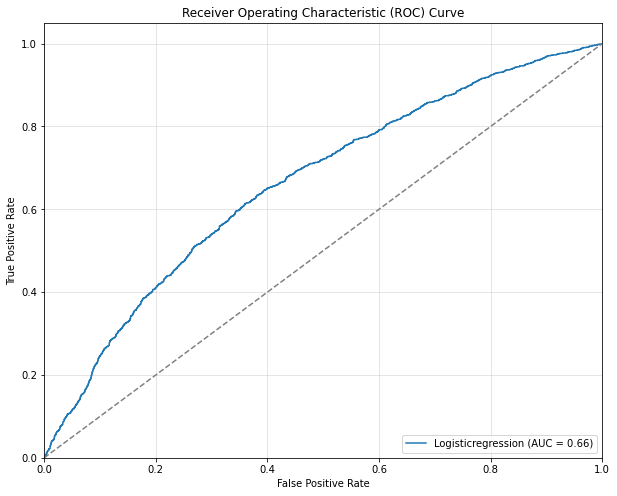

,AUROC,Precision,Recall,F1 Score
Logisticregression,0.66172,0.624573,0.624557,0.624111


In [25]:
# check the model performance
plot_roc_curve(models, X, y)
eval_metrics(models, X, y)

In [26]:
# probability estimation
colName=['less than 3 days', 'greater than or equal to 3 days']
los_prob_estimatation_from_valdata = get_probability_estimation(logreg_los, X, colName)

,less than 3 days,greater than or equal to 3 days
0,0.509363,0.490637
1,0.538280,0.461720
2,0.394143,0.605857
3,0.647051,0.352949
4,0.492372,0.507628


In [27]:
# combine with the original dataset
text_val_data = pd.concat([text_val_data, los_prob_estimatation_from_valdata], axis=1)
print('Dimension of the dataframe: ', text_val_data.shape)
text_val_data.head()

Dimension of the dataframe:  (4081, 9)


,id,los_icu_class,text,los_icu,icu_death,text_embeddings,death,less than 3 days,greater than or equal to 3 days
0,20003425,greater than or equal to 3 days,ADDENDUM Findings were communicated to the EN...,4.00,0,"[0.122243397, -0.215054199, -0.0655379891, 0.0...",0,0.509363,0.490637
1,20008724,less than 3 days,INDICATION: History: ___ with r apical ptx /...,1.37,0,"[0.076785028, -0.22386691, 0.00981518067, 0.15...",0,0.538280,0.461720
2,20009330,greater than or equal to 3 days,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,5.76,0,"[0.115483336, -0.193019524, -0.0455525294, 0.0...",1,0.394143,0.605857
3,20014219,greater than or equal to 3 days,EXAMINATION: CHEST (PORTABLE AP)\n\nINDICATIO...,19.13,0,"[0.0261465795, -0.0801570565, 0.00803710613, 0...",0,0.647051,0.352949
4,20015722,less than 3 days,EXAMINATION: CT HEAD W/O CONTRAST Q111 CT HEA...,2.60,0,"[0.212557286, -0.219507277, -0.0341315009, 0.1...",0,0.492372,0.507628


In [28]:
# export in cv file
text_val_data.to_csv('../data/text_los_probability_validation.csv', index=False)